# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Exploratory Data Analysis

In [3]:
engage = pd.read_csv("takehome_user_engagement.csv", encoding = "utf-8")
users = pd.read_csv("takehome_users.csv", encoding = "latin")

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


It is clear that we will have to use the `user_engagement` dataframe to calculate and determine whether or not a user is considered "adopted". We will then have to add these labels to the users dataframe to perform modeling.

In order to determine whether or not they are "adopted", we will use the `time_stamp` as a datetime in the `user_engagement` dataframe, set it as the index, and write a loop that will take a users logins and calculate whether or not over any 7 day period they had logged on 3 or more times.

# Data Wrangling and Preprocessing

In [8]:
#Convert time_stamp into datetime object
engage.time_stamp = pd.to_datetime(engage.time_stamp)

In [9]:
#Set time_stamp as index
engage.set_index("time_stamp", inplace=True)
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [10]:
#Determine "adopted" labels
labels = []
for i in range(1,12001):
    user_logins = engage.loc[engage.user_id == i]
    resampled = user_logins.rolling('7d').count()
    if resampled.loc[resampled.visited >= 3].shape[0] > 0:
        adopted = 1
    else:
        adopted = 0
        
    labels.append(adopted)

In [11]:
#Add labels to users dataframe
users['adopted'] = labels

In [12]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


We suspect that `creation_time` might be a useful variable, therefore we convert it from a string to a numerical value that we can put in sklearn.

In [14]:
#Create creation timestamp column
users["creation_timestamp"] = pd.to_datetime(users.creation_time)
users["creation_timestamp"] = pd.to_numeric(users.creation_timestamp) / 10**9

We can also see that there are only 8823 values for `last_session_creation_time`. Since there are quite a lot of missing values here, and we do not want to lose all the information by dropping all of these rows, we will elect to do imputation. Since this column represents the time stamp of the last login, those with no values means they simply haven't logged in. As a result, we do not think imputing the mean or median would make sense here. Instead we will impute the value of the account creation time, which represents an older date, which better represents the fact that they are not heavy or recent users.

In [15]:
#Impute account creation date for null values in last_session_creation_time
users.last_session_creation_time.fillna(users.creation_timestamp, inplace=True)

Now let's create another column that is the difference between last login time and the account creation time.

In [16]:
users["creation_last_difference"] = users["last_session_creation_time"] - users["creation_timestamp"]

We will likely not use the `invited_by_user_id` feature as One-Hot-Encoding that variable would create too many variables. Therefore, we will not worry about those missing values.

In order to add more features, we considered a couple additional options, such as the the email account domain name:

In [17]:
#Try creating email domain feature
split_emails = users.email.str.split('@')
email_domain = [x[1] for x in split_emails]
users["email_domain"] = pd.Series(email_domain)

In [18]:
len(pd.Series(users.email_domain).unique())

1184

However, one can see with over 1000 unique email domains, this is not a feasible feature as I would have to one-hot-encode the column thus adding over 1000 columns. Therefore we will leave it out.

Let's now inspect the new dataframe:

In [19]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_timestamp,creation_last_difference,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1.398139e+09,0.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1.384487e+09,11750400.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1.363735e+09,0.0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1.369124e+09,86400.0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1.358418e+09,432000.0,yahoo.com


In [20]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_timestamp,creation_last_difference
count,12000.00000,1.200000e+04,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,1.200000e+04,1.200000e+04
mean,6000.50000,1.377743e+09,0.249500,0.149333,141.884583,5962.957145,0.133500,1.373981e+09,3.762122e+06
std,3464.24595,1.952576e+07,0.432742,0.356432,124.056723,3383.761968,0.340128,1.871814e+07,1.091685e+07
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,1.338425e+09,0.000000e+00
25%,3000.75000,1.361464e+09,0.000000,0.000000,29.000000,3058.000000,0.000000,1.358285e+09,0.000000e+00
50%,6000.50000,1.380630e+09,0.000000,0.000000,108.000000,5954.000000,0.000000,1.375739e+09,0.000000e+00
75%,9000.25000,1.396570e+09,0.000000,0.000000,238.250000,8817.000000,0.000000,1.390904e+09,2.592000e+05
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,1.401494e+09,6.298560e+07


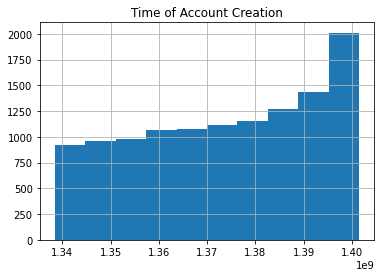

In [21]:
users.creation_timestamp.astype("int64").hist()
plt.title("Time of Account Creation")
plt.show()

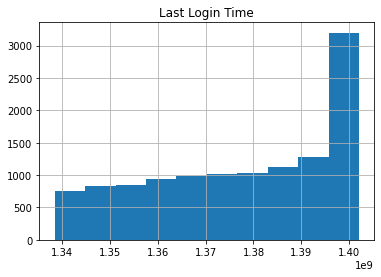

In [22]:
users.last_session_creation_time.astype("int64").hist()
plt.title("Last Login Time")
plt.show()

In [23]:
#One hot encode categorical variables
categorical_cols = ["creation_source"]
categorical_data = users[categorical_cols]
enc = OneHotEncoder(categories='auto', sparse=False, drop="first")
enc_cat_data = pd.DataFrame(enc.fit_transform(categorical_data))
enc_cat_data.columns = enc.get_feature_names_out(input_features=None)
enc_cat_data.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [24]:
#Select numerical features
numerical_data = users[["last_session_creation_time",
                        "opted_in_to_mailing_list",
                        "enabled_for_marketing_drip",
                        "adopted",
                        "creation_timestamp", 
                        "creation_last_difference"]]

In [25]:
#Merge numerical and OneHotEncoded data
model_data = pd.merge(numerical_data, enc_cat_data, how="left", left_index=True, right_index=True)

In [26]:
model_data.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,creation_timestamp,creation_last_difference,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,0,1.398139e+09,0.0,0.0,0.0,0.0,0.0
1,1.396238e+09,0,0,1,1.384487e+09,11750400.0,1.0,0.0,0.0,0.0
2,1.363735e+09,0,0,0,1.363735e+09,0.0,1.0,0.0,0.0,0.0
3,1.369210e+09,0,0,0,1.369124e+09,86400.0,0.0,0.0,0.0,0.0
4,1.358850e+09,0,0,0,1.358418e+09,432000.0,0.0,0.0,0.0,0.0


In [27]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   last_session_creation_time          12000 non-null  float64
 1   opted_in_to_mailing_list            12000 non-null  int64  
 2   enabled_for_marketing_drip          12000 non-null  int64  
 3   adopted                             12000 non-null  int64  
 4   creation_timestamp                  12000 non-null  float64
 5   creation_last_difference            12000 non-null  float64
 6   creation_source_ORG_INVITE          12000 non-null  float64
 7   creation_source_PERSONAL_PROJECTS   12000 non-null  float64
 8   creation_source_SIGNUP              12000 non-null  float64
 9   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 937.6 KB


In [28]:
model_data.adopted.mean()

0.1335

We see the target variable (whether they are an adopted user or not), is very imbalanced with only 13.35% being adopted.

In order to answer the question, we will create some models and look at the feature importances. We begin with a simple random forest model as it can easily display feature importances:

# Model Development

## Random Forest

In [29]:
target_column = "adopted"
X = model_data.drop(target_column, axis=1)
y = model_data[[target_column]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
n_estimator_space = [50, 100, 200]
max_features_space = [2, 'sqrt', 5]
class_weight_space = ['balanced', 'balanced_subsample', None]
criterion_space = ['gini', 'entropy']
param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'class_weight': class_weight_space, 
              'criterion': criterion_space}
rf_tune = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_tune, param_grid, cv=3, scoring='roc_auc')
rf_cv.fit(X_train, y_train.values.ravel())
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_features': 5, 'n_estimators': 200}
0.9926607817962353


### Best Parameters

In [31]:
#Random forest with best parameters
rf = RandomForestClassifier(n_estimators = 200,
                           max_features = 5,
                           criterion = "gini",
                           class_weight=None,
                           random_state=42)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2055   25]
 [  43  277]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2080
           1       0.92      0.87      0.89       320

    accuracy                           0.97      2400
   macro avg       0.95      0.93      0.94      2400
weighted avg       0.97      0.97      0.97      2400



### ROC Curve

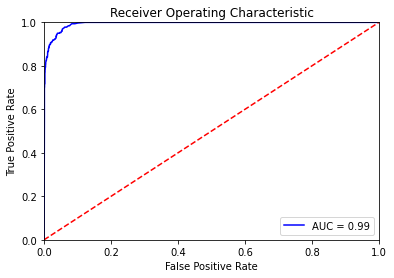

In [32]:
#RF ROC Curve
probs = y_prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs, pos_label=1.)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

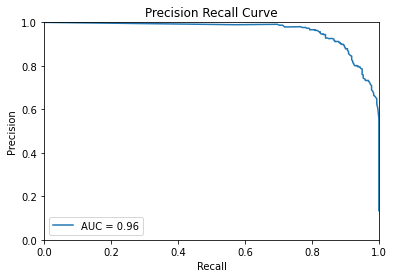

In [33]:
#RF Precision-Recall Curve
probs = y_prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Feature Importance

In [34]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = X_train.columns
feature_importances["importance"] = rf_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
4,creation_last_difference,0.658136
0,last_session_creation_time,0.220865
3,creation_timestamp,0.096777
1,opted_in_to_mailing_list,0.004672
5,creation_source_ORG_INVITE,0.004561
8,creation_source_SIGNUP_GOOGLE_AUTH,0.004457
2,enabled_for_marketing_drip,0.004091
7,creation_source_SIGNUP,0.003386
6,creation_source_PERSONAL_PROJECTS,0.003055


We see how by a large margin the most important features are `creation_last_difference`, the difference in time between account creation and the last login, `last_session_creation_time`, the time of last login, and `creation_timestamp`, the time of account creation.

Not that the models performance could get much better, but let's try another model. This time we will use a Gradient Boosting Classifier:

## Gradient Boosting Classifier

In [35]:
n_estimator_space = [50, 100, 200, 500]
max_features_space = [2, 'sqrt', 5, 7]
learning_rate_space = [0.01, 0.1, 0.5,  1]
loss_space = ['deviance', 'exponential']

param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'learning_rate': learning_rate_space, 
              'loss': loss_space}
gb_tune = GradientBoostingClassifier(random_state=42)
gb_cv = GridSearchCV(gb_tune, param_grid, cv=3, scoring='roc_auc')
gb_cv.fit(X_train, y_train.values.ravel())
print(gb_cv.best_params_)
print(gb_cv.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  war

{'learning_rate': 0.1, 'loss': 'exponential', 'max_features': 'sqrt', 'n_estimators': 50}
0.9943496850229859


### Best Parameters

In [36]:
|#Gradient Boosting with best parameters
gb = GradientBoostingClassifier(n_estimators=50, 
                                learning_rate=0.1, 
                                loss='exponential', 
                                max_features='sqrt', 
                                random_state=42)
gb_model = gb.fit(X_train, y_train.values.ravel())
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2057   23]
 [  36  284]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2080
           1       0.93      0.89      0.91       320

    accuracy                           0.98      2400
   macro avg       0.95      0.94      0.95      2400
weighted avg       0.98      0.98      0.98      2400



### ROC Curve

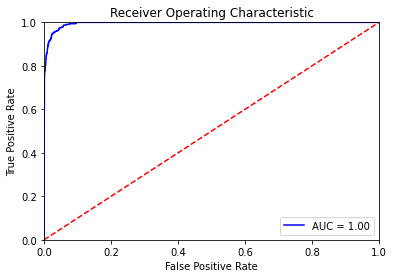

In [38]:
#GB ROC Curve
probs = y_prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs, pos_label=1.)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

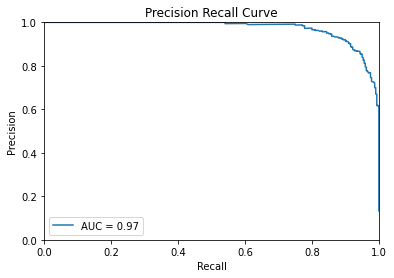

In [39]:
#GB Precision-Recall Curve
probs = y_prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Feature Importance

In [40]:
#GB Feature Importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = X_train.columns
feature_importances["importance"] = gb_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
4,creation_last_difference,0.727249
0,last_session_creation_time,0.240996
3,creation_timestamp,0.029838
6,creation_source_PERSONAL_PROJECTS,0.001077
2,enabled_for_marketing_drip,0.000225
1,opted_in_to_mailing_list,0.000213
8,creation_source_SIGNUP_GOOGLE_AUTH,0.000185
5,creation_source_ORG_INVITE,0.000152
7,creation_source_SIGNUP,0.000064


Once again the model performs very well and we same the same top 3 features. Let's explore these 3 features in more detail:

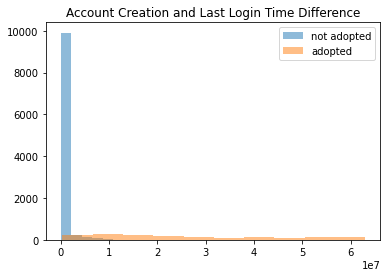

In [41]:
#Inspect creation_last_difference
adopted = model_data.loc[model_data.adopted == 1]["creation_last_difference"]
not_adopted = model_data.loc[model_data.adopted == 0]["creation_last_difference"]

plt.hist(not_adopted, bins = 10, alpha=0.5, label="not adopted")
plt.hist(adopted, bins = 10, alpha=0.5, label="adopted")
plt.legend()
plt.title("Account Creation and Last Login Time Difference")
plt.show()

We can see the major difference in the distributions of those who are considered adopted and those who are not. This seems reasonable as the difference between the last login and account creation time is very small for those who are not adopted. This suggests that they do not use the application over a long period of time.

<function matplotlib.pyplot.show(close=None, block=None)>

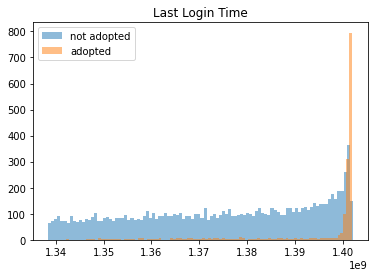

In [42]:
#Inspect last_session_creation_time
adopted = model_data.loc[model_data.adopted == 1]["last_session_creation_time"]
not_adopted = model_data.loc[model_data.adopted == 0]["last_session_creation_time"]

plt.hist(not_adopted, bins = 100, alpha=0.5, label="not adopted")
plt.hist(adopted, bins = 100, alpha=0.5, label="adopted")
plt.legend()
plt.title("Last Login Time")
plt.show()

We see how the adopted users seem to concentrate at much more recent last login times.

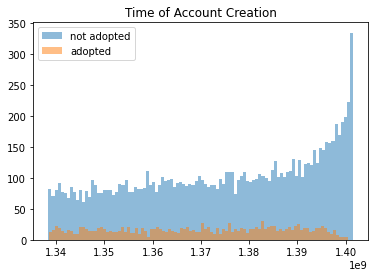

In [43]:
#Inspect creation_timestamp
adopted = model_data.loc[model_data.adopted == 1]["creation_timestamp"]
not_adopted = model_data.loc[model_data.adopted == 0]["creation_timestamp"]

plt.hist(not_adopted, bins = 100, alpha=0.5, label="not adopted")
plt.hist(adopted, bins = 100, alpha=0.5, label="adopted")
plt.legend()
plt.title("Time of Account Creation")
plt.show()

# Conclusion

Here we can see some deviance at the right end of the distribution. This might be explained by the fact that recent sign ups have not had enough time to meet the criteria of "adopted" (3 logins within one week), or it could be some change in the application that caused a decrease in adoption.

In conclusion, we can see that these models perform extremely well in predicting who will adopt. In addition, it seems clear that `creation_last_difference`, `last_session_creation_time`, and `creation_timestamp` |are the factors which best predict user adoption.